In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:80% !important; }</style>")

In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mplPath

import seaborn as sns

from scipy import ndimage, misc

sns.set(color_codes=True)

%matplotlib inline


In [3]:
from image_utils import harrisResponse, response2points, nonMaximalSuppression

from scipy.spatial import Delaunay

In [73]:
#art = misc.imread("pictures/orlok.jpg")
art = misc.imread("pictures/marceline.jpg")

In [74]:
art.shape

(1227, 900, 3)

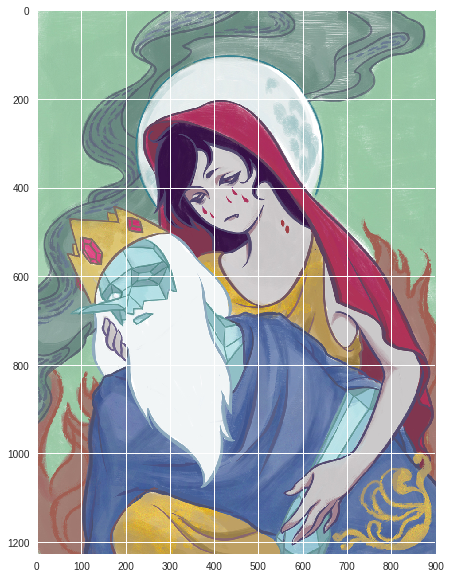

In [75]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(art)

plt.show()

In [76]:
hsv_art = mpl.colors.rgb_to_hsv(art)
rgb_art = mpl.colors.hsv_to_rgb(hsv_art).astype(int)

#### Blur an image

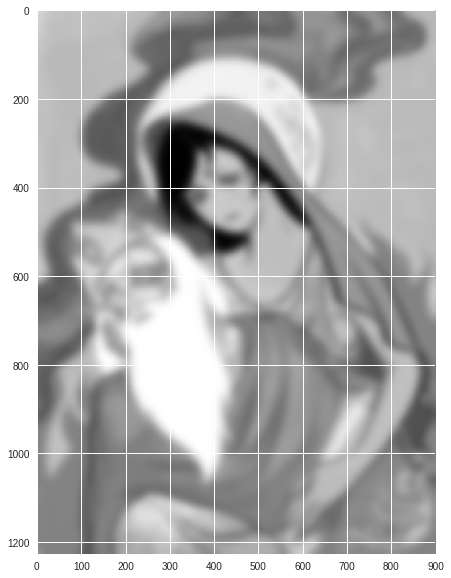

In [77]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

#axs.imshow(hsv_art[:,:,1])
im_smooth = np.zeros(hsv_art[:,:,0].shape)
ndimage.filters.gaussian_filter(hsv_art[:,:,2], (10,10), (0,0), im_smooth)
#axs.imshow(hsv_art[:,:,1] - im_smooth)

axs.imshow(im_smooth, cmap='gray')
plt.show()

# fig = plt.figure(figsize=(10,10))
# axs = fig.add_subplot(111)

# sharp_im = hsv_art[:,:,2] - im_smooth
# sharp_im = sharp_im + np.min(sharp_im)
# axs.imshow(sharp_im + np.min(sharp_im), cmap = 'gray')

# plt.show()

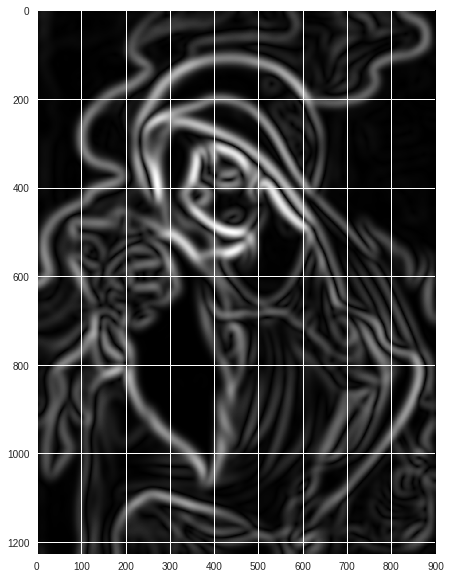

In [78]:
im_x = np.zeros(im_smooth.shape)
sigma = 2
ndimage.filters.gaussian_filter(im_smooth, (sigma,sigma), (0,1), im_x)

im_y = np.zeros(im_smooth.shape)
ndimage.filters.gaussian_filter(im_smooth, (sigma,sigma), (1,0), im_y)
plt.show()

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
smooth_grad_mag = np.sqrt(im_y**2 + im_x**2)
axs.imshow(smooth_grad_mag, cmap = 'gray')

plt.show()


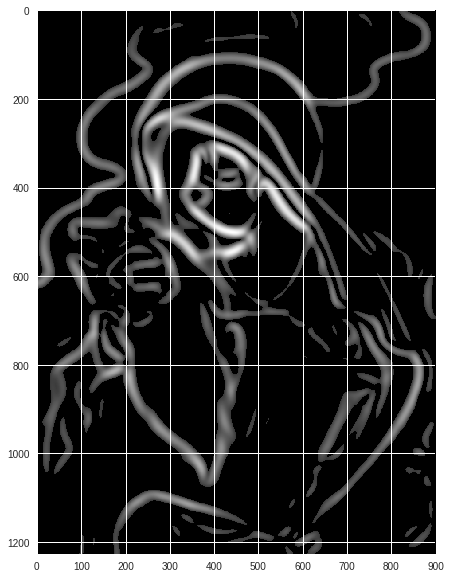

In [79]:
smooth_grad_thresh = smooth_grad_mag.copy()
smooth_grad_thresh[smooth_grad_thresh < 1.2] = 0

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(smooth_grad_thresh, cmap='gray')
plt.show()

#### Enhance contrast

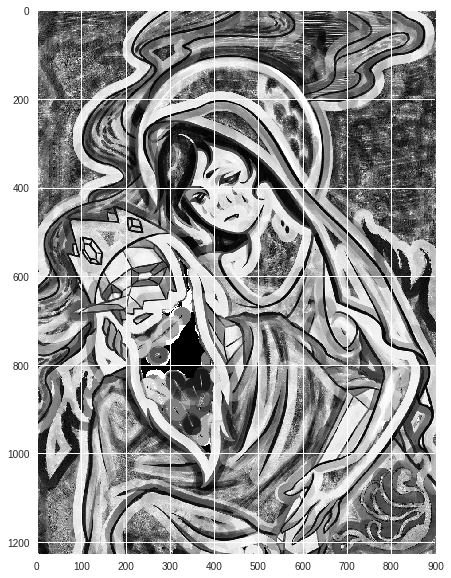

In [80]:
from skimage.filters.rank import autolevel_percentile
from skimage.filters.rank import autolevel
from skimage.morphology import disk

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

selem = disk(20)
loc_autolevel = autolevel(hsv_art[:,:,2] / 256.0, selem=selem)

axs.imshow(loc_autolevel, cmap='gray')
plt.show()



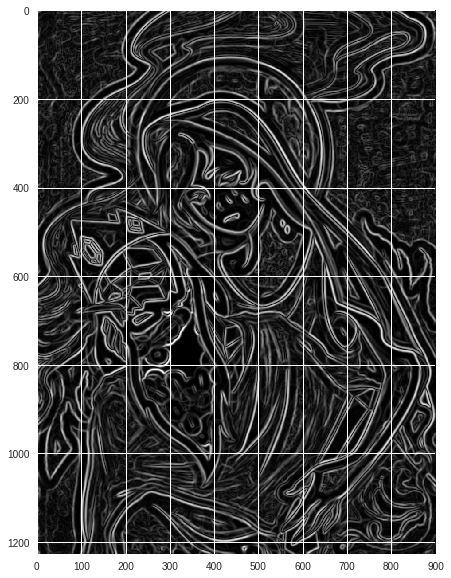

In [81]:
im_x = np.zeros(loc_autolevel.shape)
sigma = 2
ndimage.filters.gaussian_filter(loc_autolevel, (sigma,sigma), (0,1), im_x)

im_y = np.zeros(loc_autolevel.shape)
ndimage.filters.gaussian_filter(loc_autolevel, (sigma,sigma), (1,0), im_y)
plt.show()

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
sharp_grad_mag = np.sqrt(im_y**2 + im_x**2)
axs.imshow(sharp_grad_mag, cmap = 'gray')

plt.show()


#### Edge distribution

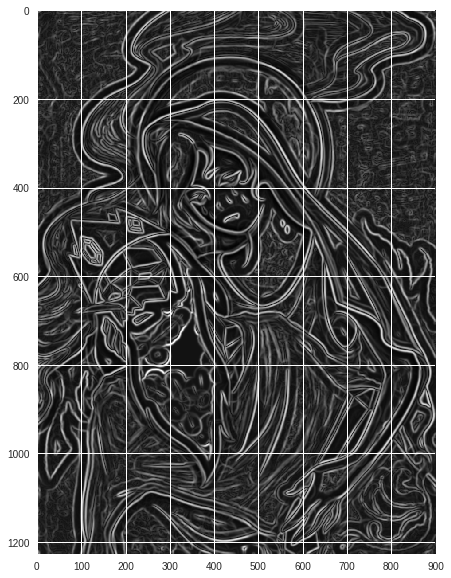

In [82]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(sharp_grad_mag - smooth_grad_mag, cmap='gray')
plt.show()

Ps = (sharp_grad_mag - smooth_grad_mag)
#Ps /= np.sum(Ps)
#xs = np.arange(Ps.shape[0])



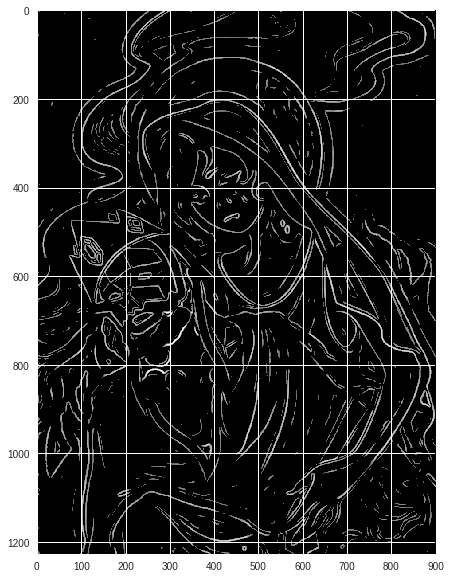

In [83]:
Ps_thresh = Ps.copy()
Ps_thresh[Ps_thresh < 20] = 0

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)

axs.imshow(Ps_thresh, cmap='gray')
plt.show()

In [84]:
x_range = np.arange(sharp_grad_mag.shape[1])
y_range = np.arange(sharp_grad_mag.shape[0])
xi, yi = np.meshgrid(x_range,y_range)
inds = np.array([xi.ravel(), yi.ravel()]).T

### Getting edgier

In [85]:
from skimage import feature

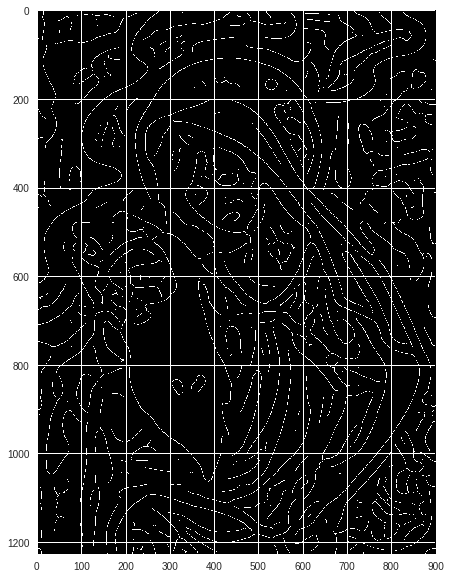

In [86]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
edges = feature.canny(im_smooth, sigma=1)
axs.imshow(edges, cmap = 'gray')

plt.show()

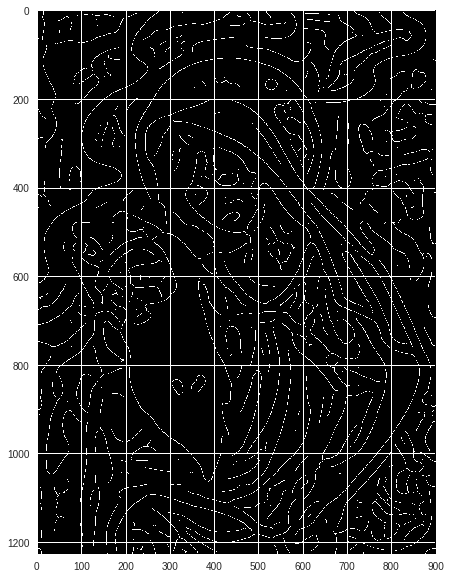

In [87]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
edges2 = feature.canny(loc_autolevel, sigma=5)
axs.imshow(edges, cmap = 'gray')

plt.show()

/home/caesarq/.virtualenvs/world/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  app.launch_new_instance()
/home/caesarq/.virtualenvs/world/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


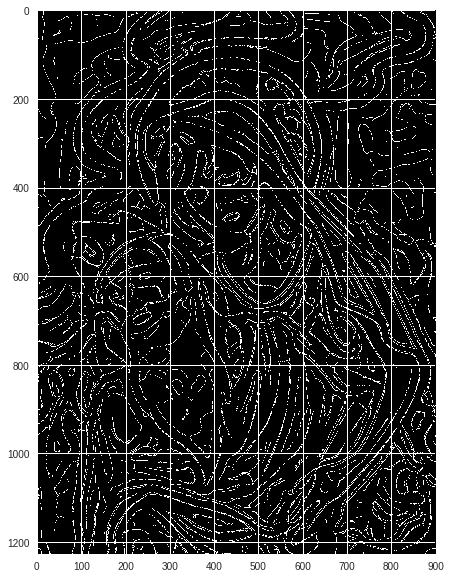

In [88]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(edges2 - edges, cmap = 'gray')
p_edges = edges2 - edges

plt.show()

### With voronoi

In [89]:
def unique_rows(a):
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))
    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

In [90]:
def genRandomBorderPoints(max_n, min_dist, rng):
    candids = np.arange(min_dist, max_n - min_dist)
    border = [0, max_n]
    
    while True:
        try:
            ind = rng.choice(candids)
        except ValueError:
            border = np.asarray(border)
            border = np.sort(border)
            return border
        
        border.append(ind)
        candids = candids[np.logical_or(candids < ind - min_dist,
                                        candids > ind + min_dist)]

    

(535, 2)


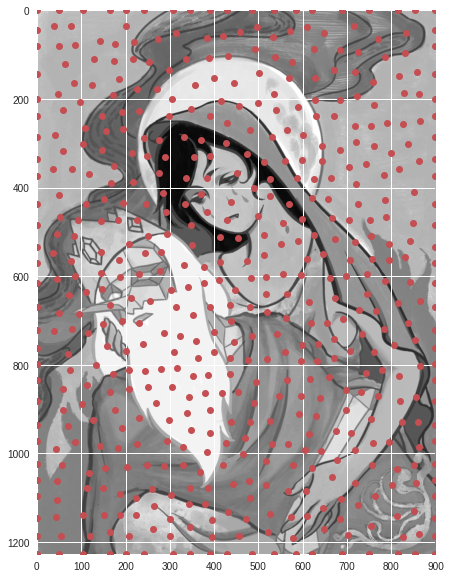

In [91]:
x_range = np.arange(sharp_grad_mag.shape[0])
y_range = np.arange(sharp_grad_mag.shape[1])
xi, yi = np.meshgrid(x_range,y_range)
inds = np.array([xi.ravel(), yi.ravel()]).T

edge_points = np.nonzero(p_edges.flatten())[0]
edge_points = np.asarray([inds[pt] for pt in edge_points]).tolist()
values = np.asarray([loc_autolevel[p[0],p[1]] for p in edge_points])
index = np.argsort(values)

min_dist = 35
# # select the best points taking min_distance into account
filtered_coords = nonMaximalSuppression(index, edge_points, 
                                        loc_autolevel.shape, min_dist).tolist()

rng = np.random.RandomState(223245)
x_range = genRandomBorderPoints(sharp_grad_mag.shape[0] - 1, min_dist, rng)
y_range = genRandomBorderPoints(sharp_grad_mag.shape[1] - 1, min_dist, rng)

lft_row = [[0, yi] for yi in y_range]
filtered_coords.extend(lft_row)

rht_row = [[x_range[-1], yi] for yi in y_range]
filtered_coords.extend(rht_row)

top_row = [[xi, 0] for xi in x_range]
filtered_coords.extend(top_row)

bot_row = [[xi, y_range[-1]] for xi in x_range]
filtered_coords.extend(bot_row)

points = np.array(filtered_coords)
points = unique_rows(points)
points = points[:,::-1]
print points.shape

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(hsv_art[:,:,2], cmap = 'gray', interpolation='bilinear')
axs.plot(points[:,0], points[:,1], 'ro')


plt.show()

### Points to voronoi

#### Mosaic pattern

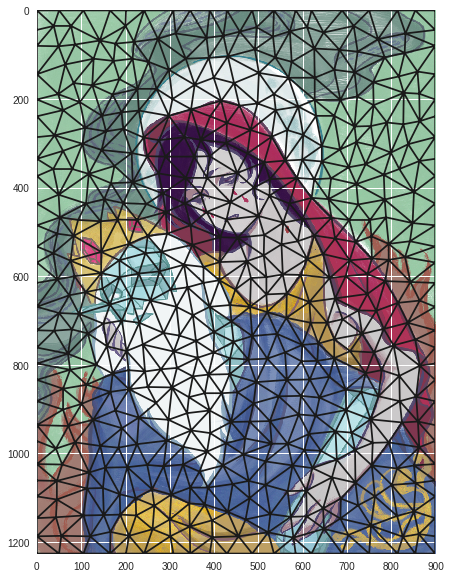

In [92]:
tri = Delaunay(points)

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(art)
axs.triplot(points[:,0], points[:,1], tri.simplices.copy(), 'k-')


plt.show()


In [93]:
from tqdm import tqdm_notebook

In [94]:
def path2chunk(path, inds):
    contains = np.array([path.contains_point(ind) for ind in inds])
    keep = inds[np.where(contains)]
    return keep

In [95]:
import cv2

In [96]:
def fillTriangle(tr, art_img, new_img):
    r = cv2.boundingRect(np.float32([tr]))
    t_rec = []
    for i in xrange(0, 3):
        t_rec.append(((tr[i][0] - r[0]),(tr[i][1] - r[1])))
    
    
    mask = np.zeros((r[3], r[2]), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t_rec), (1.0, 1.0, 1.0), 16, 0);
    art_img_patch = art_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]

    kx, ky = np.where(mask == 1)
    vals = np.mean(art_img_patch[kx,ky,:], axis=0).astype('int')
    
    #print art_img_patch.shape
    new_img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]][kx,ky,:] = vals[None,None,:] #* (mask[:,:,None])
    #art_img_patch * (mask[:,:,None] ) + 
        
    

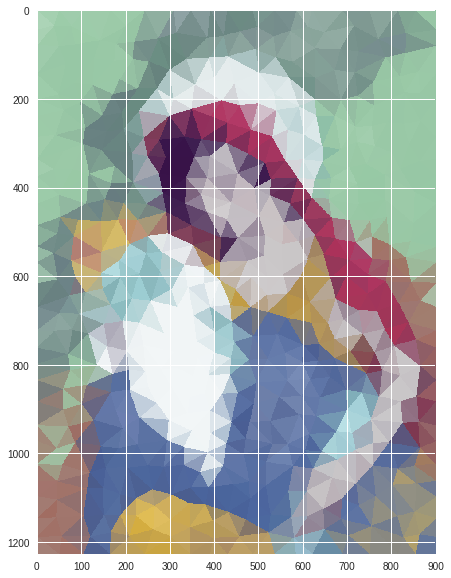

In [97]:
new_image = np.zeros(art.shape)

for i, region in tqdm_notebook(enumerate(tri.simplices), desc='regions'):

    vertices = points[region] 

    fillTriangle(vertices, 256 - art, new_image)
        

fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
axs.imshow(new_image, interpolation='nearest')

plt.show()

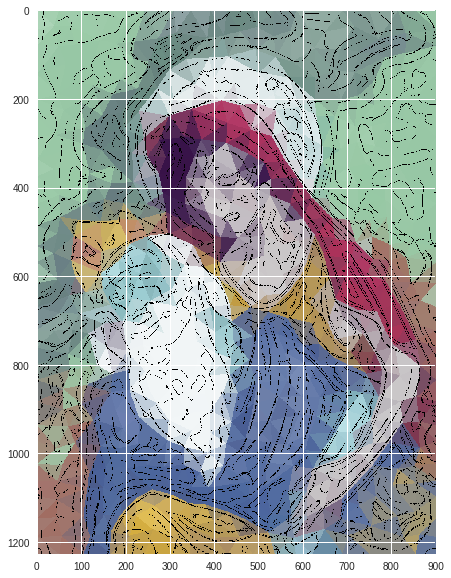

In [98]:
fig = plt.figure(figsize=(10,10))
axs = fig.add_subplot(111)
#axs.imshow(new_image[:,:,0], cmap=plt.cm.gist_heat)
#axs.imshow(new_image[:,:,2], cmap='gray')
#axs.imshow(256 - new_image)
#axs.imshow(fill_art, alpha=0.2)
windowed_art = new_image
windowed_art[p_edges] = 0
axs.imshow(windowed_art)
#axs.imshow(new_image)

plt.show()

In [99]:
x_range = np.arange(sharp_grad_mag.shape[1])
y_range = np.arange(sharp_grad_mag.shape[0])
xi, yi = np.meshgrid(x_range,y_range)
all_inds = np.array([xi.ravel(), yi.ravel()]).T

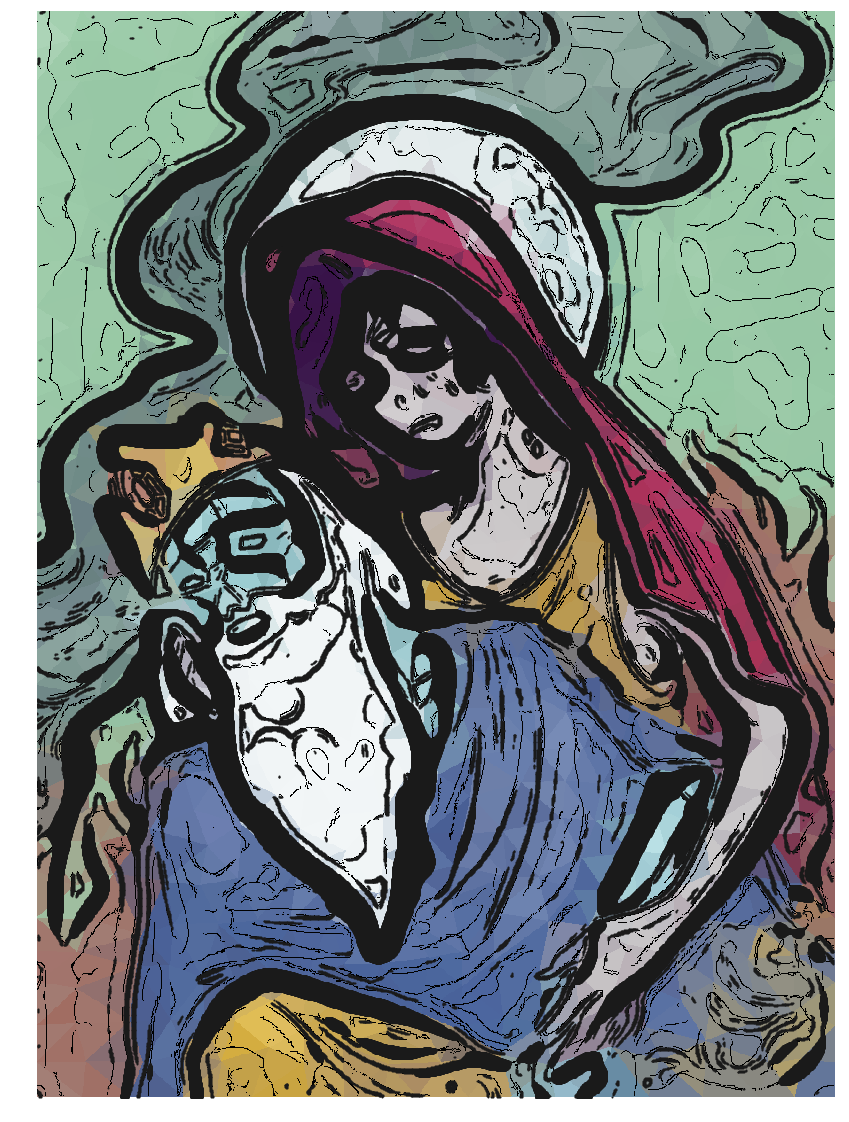

In [100]:
fig = plt.figure(figsize=(20,20))
axs = fig.add_subplot(111)

axs.imshow(art, alpha=0.2)
axs.imshow(new_image)

cast_edge_points = np.nonzero(smooth_grad_thresh.flatten())[0]
cast_edge_points = all_inds[cast_edge_points]
axs.plot(cast_edge_points[:,0], cast_edge_points[:,1], 'ko', ms=3)

cast_edge_points = np.nonzero(Ps_thresh.flatten())[0]
cast_edge_points = all_inds[cast_edge_points]
axs.plot(cast_edge_points[:,0], cast_edge_points[:,1], 'ko', ms=2)

axs.set_xlim((0, new_image.shape[1]))
axs.set_ylim((new_image.shape[0],0))

plt.axis('off')
plt.show()

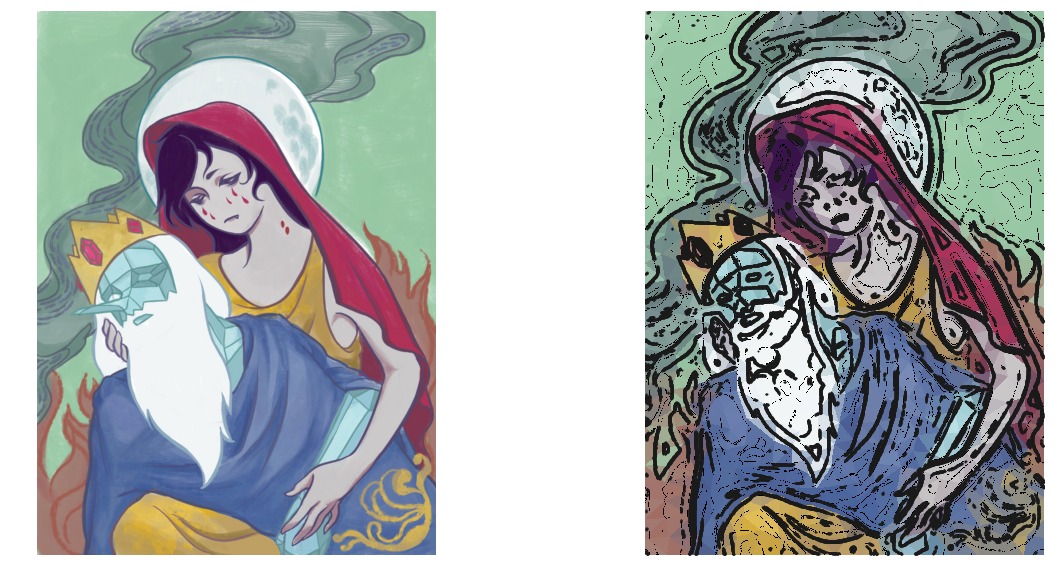

In [103]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].imshow(art, interpolation='bilinear')
axs[0].axis("off")

#axs[1].imshow(art, alpha=0.2, interpolation='bilinear')
axs[1].imshow(new_image)

cast_edge_points = np.nonzero(smooth_grad_thresh.flatten())[0]
cast_edge_points = all_inds[cast_edge_points]
#axs[1].plot(cast_edge_points[:,0], cast_edge_points[:,1], 'ko', ms=3)

cast_edge_points = np.nonzero(Ps_thresh.flatten())[0]
cast_edge_points = all_inds[cast_edge_points]

axs[1].plot(cast_edge_points[:,0], cast_edge_points[:,1], 'ko', ms=2)

axs[1].set_xlim((0, new_image.shape[1]))
axs[1].set_ylim((new_image.shape[0],0))

axs[1].axis('off')


plt.show()